In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

import target_predicting_RF_function_and_feature_ranking_TNGSIM as functions
import RF_target_predicting_and_learning_curves_functions_TNGSIM as tp_lc_functions

In [2]:
# Using the 0D TNG100 SIM data at z=0 (version 5 of the dataset in this notebook, 
# for further explanation see Notebook v3 updated and v14)

df_0D = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v5_TNG-SIM_0D_Dataset.csv')
df_raw = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v4_TNG-SIM_Raw_Dataset.csv')
print("df_0D.shape", df_0D.shape)
print("df_raw.shape", df_raw.shape)

df_0D.shape (21598, 16)
df_raw.shape (21598, 19)


### <font color='purple'> <a id =10> </a> <br> Take Log10 of all features and target, both 0D & raw

In [3]:
def log_df(df_init):
    
    df = df_init.copy()
    for feature in df.columns.to_list():
        if 'log' not in feature:
            df.loc[:, feature + '_log']=df.loc[:,feature].apply(lambda x: np.log10(x + 1.e-8))
            df.drop(columns = [feature], inplace = True)
#             print(df.loc[:, feature])
        else:continue
        
    return df

In [4]:
df_raw_log = log_df(df_raw)

In [5]:
df_raw_log.head(2)

SubhaloBHMass_log  SubhaloBHMdot_log  SubhaloGasMetallicity_log  \
0           9.998109          -3.400095                  -2.112483   
1           9.898275          -4.012083                  -2.359742   

   SubhaloSFRinRad_log  SubhaloStarMetallicity_log  SubhaloVelDisp_log  \
0            -0.708133                   -1.543295            2.780947   
1             0.219496                   -1.679031            2.774496   

   SubhaloVmax_log  SubhaloVmaxRad_log  SubhaloRgas_log  SubhaloRstar_log  \
0         2.999733            2.668073         2.949910          1.828096   
1         2.981978            3.134860         2.988572          2.098578   

   SubhaloMgas_log  SubhaloMstar_log  GroupNsubs_log  Group_M_TopHat200_log  \
0        13.092064         12.497443        4.235150              14.646987   
1        13.610459         12.316876        4.150971              14.687475   

   Group_R_TopHat200_log  SubhaloMHI_log  SubhaloMH2_log  \
0               3.292134       10.061858       10.043734   
1               3.305635        9.899765        9.955786   

   Group_V_TopHat200_log  GroupSpin_dmo_log  
0               2.994161          -1.769689  
1               3.007654          -1.893303

In [6]:
df_raw_log.shape

(21598, 19)

In [7]:
df_raw.shape

(21598, 19)

In [8]:
df_0D_log = log_df(df_0D)

In [9]:
df_0D_log.shape

(21598, 16)

In [10]:
df_0D.shape

(21598, 16)

### <font color='purple'> <a id =10> </a> <br> Disks only Raw Dataset: How to select disk-only galaxies?

#### Discussions with Ari regarding the definition of disk galaxies in SIMs:

##### <font color='purple'> (From Slack, October 27th 2023: TNG-SIM SFR vs Mstar in 50, 100, 300 boxes)

Festa: (Referencing the SFR vs Mstar plots for the three TNG boxes) I do not see in simulations the increasing slope followed by a constant-like trend that you once showed me in a plot like this (from observations, if I recall correctly).

Ari: Yes, this is what I mentioned some time ago, if you just use the 50 box, you will basically have only disk galaxies.  But you can see you could also take logMstar < 10 for the 100 box and get almost all disk too. So I think the question is the number of galaxies. If you think the 50 box has enough I might try there, but they are pretty low mass. You might want to fit a median line to the points that make what is called the star forming sequence and take only the upper half.
It does look like in different boxes galaxies with the same mass and SFR have different sizes, which is not good. But nothing we can do about it.

Festa: There are ~13,000 galaxies in the 50 box, so the number is not bad. It’s just that they are low mass. Probably choosing the upper half of the median line in the 100 box is better. 
As for the galaxies with same mass and SFR having different sizes in different boxes, I wonder if this looks so more because of the density of points in the plot(in 300 box for example). Maybe a 2D density plot would show that better.

##### <font color='purple'> (From Slack, October 30th 2023: TNG100-SIM Raw + Mstar_0D dataset: RF results & Feature Ranking end of thread)

Festa: Galaxy star forming sequence is the median of instantaneous SFR?

Ari: the star forming sequence is the blob that you can see by eye, there are all kinds of fights about how to define it, but I think if you took the median in some bins, or just fit linear regression you would get something that by eye fits it pretty well.

##### <font color='purple'> (From Slack, November 7th 2023: TNG 50, 100 & 300: LogRstar vs LogMstar, and LogSFR vs LogMstar)

Festa: (referencing the plots) Hi @Ari! I plotted the mean SFR vs mean Mstar for the three TNG boxes in order to select the disks. While at it, I also looked at how Rstar vs Mstar compares for the three of them.
The horizontal line in the last two plots corresponds to SFR=0; TNG100 box has 8% of SFR=0 galaxies, TNG300 has ~30% of them. 

If I want to choose disks from the TNG100 box, looking at the last plot, I think I should choose galaxies lying in the upper side of the increasing slope from logMstar=8 to logMstar=10.5ish. Is this correct? Also, I believe I should remove SFR=0 galaxies, right?

Ari: Hi @Festa, looks good. I'm glad to see that the overlap between boxes is pretty good.
Yes, I think taking values above your median line from 8 to 10.5 is a good 'star forming' sample.  I think it better to set the SFR=0 to a low value like -3.5 instead of removing them. If I remember correctly they are just set incorrectly in log space. Or just don't include them in your sample, that has the same effect.

Festa: The SFR=0 here are the true SFR=0. So I took log of everything that is not 0 only.

Ari: so then I would set them to -3.5 so you get the median right.

Festa: @Ari I used mean SFR per logMstar bin for these plots, and if I change SFR=0s to -3.5, the mean changes. slightly.



Note: 1,715 galaxies have SFR=0. That is ~8% of the dataset.

In [11]:
df_raw_log.SubhaloSFRinRad_log.describe()

count    21598.000000
mean        -1.427900
std          2.028631
min         -8.000000
25%         -1.396941
50%         -0.931970
75%         -0.476214
max          1.994171
Name: SubhaloSFRinRad_log, dtype: float64

### <font color='purple'> <a id =10> </a> <br> Defining Disk galaxies in TNG-SIM using the SFR vs Mstar plot

##### <font color='purple'> (From Slack, March 6th 2024: Defining disk galaxies in TNG-SIM)
Ari: (referring to the plots below)You can see that most of the points make a finger that touches the scattered red points. I would just draw a line by eye through that cloud, like (8.5,-1.5) to (10,0.0) and only take the points above that line. I know that's not a data driven algorithm, but I don't think there is any reason to trust anything more formal. If it actually works we can go back and try to come up with a better reason for the cut, but we should first see that it works at all.
    
    Therefore, I use the slope defined by the two points A[8.5,-1.5] and B[10,0.0] as a boundary, and choose only galaxies in the upper side of the slope.
    
Ari: I think on this we want to feel that our sample is really likely to be all disk galaxies even if that means we excluded a lot of disks.

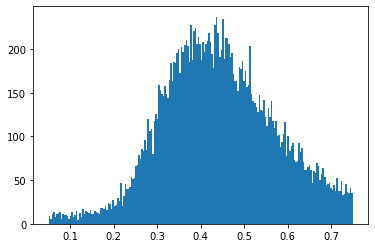

In [12]:
plt.hist(df_raw_log.SubhaloRstar_log, bins=200, range=(0.05, 0.75))
plt.show()

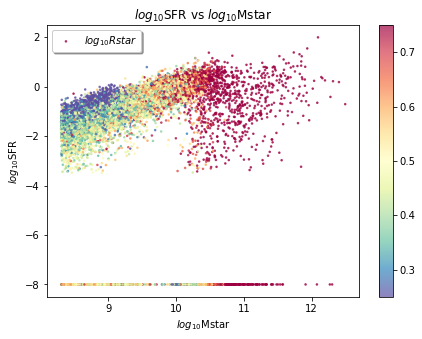

In [13]:
# Plot of log SFR vs log Mstar to see the trend and define disk galaxies

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw_log.SubhaloMstar_log, df_raw_log.SubhaloSFRinRad_log,
            c = df_raw_log.SubhaloRstar_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}Rstar$', vmin=0.25, vmax=0.75)
# ax.text(-0.15, 1.35, r'$R^{2}$ score=blabla', size=12)
# ax.axis([8.0,12.5, -4, 2.0])
# ax.plot([-1.0, 2.0], [-1.0, 2.0], color = 'black', linewidth = 2)
ax.set_title(r'$log_{10}$SFR vs $log_{10}$Mstar')
ax.set_xlabel(r'$log_{10}$Mstar')
ax.legend(loc = 'upper left', shadow=True)
ax.set_ylabel(r'$log_{10}$SFR')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v21_Disks_RF_FeatRank_Raw/SFR_vs_Mstar_colorRstar.jpeg', dpi=500)
plt.show()

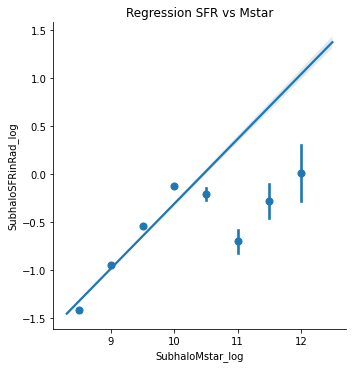

In [14]:
sns.lmplot(x = 'SubhaloMstar_log', y = 'SubhaloSFRinRad_log', data=df_raw_log[df_raw_log.SubhaloSFRinRad_log>-5],
           fit_reg=True, x_bins=[8,8.5,9, 9.5, 10, 10.5, 11, 11.5, 12],
          markers='o')

plt.title('Regression SFR vs Mstar')
plt.show()

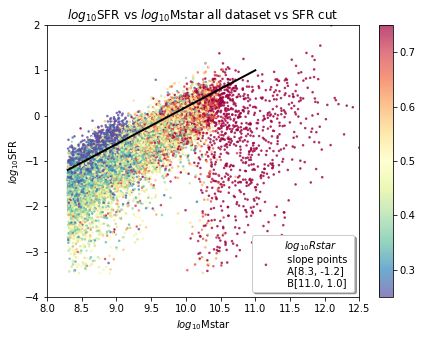

In [15]:
# Use the slope defined here to select Disk galaxy population for TNG-SIM
fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR1 = ax.scatter(df_raw_log.SubhaloMstar_log, df_raw_log.SubhaloSFRinRad_log,
            c = df_raw_log.SubhaloRstar_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}Rstar$' + '\n slope points \n A[8.3, -1.2] \n B[11.0, 1.0]', vmin=0.25, vmax=0.75)
#fig_SR = ax.scatter(df_sfrcut_raw_log2.SubhaloMstar_log, df_sfrcut_raw_log2.SubhaloSFRinRad_log,
            #c = df_sfrcut_raw_log2.SubhaloRstar_log, 
            #s=10, marker='.', alpha=0.3,label= r'SFR subset') #, vmin=0.25, vmax=0.75)

# ax.text(-0.15, 1.35, r'$R^{2}$ score=blabla', size=12)
ax.axis([8.0,12.5, -4, 2.0])
ax.plot([8.3, 11.0], [-1.2, 1.0], color = 'black', linewidth = 2)
ax.set_title(r'$log_{10}$SFR vs $log_{10}$Mstar all dataset vs SFR cut')
ax.set_xlabel(r'$log_{10}$Mstar')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel(r'$log_{10}$SFR')
fig_complete.colorbar(fig_SR1, ax=ax)
# plt.savefig('TNG-SIM_images/v21_Disks_RF_FeatRank_Raw/SFR_vs_Mstar_colorRstar_slope4.jpeg', dpi=500)
plt.show()

In [16]:
df_mstarcut_raw_log = df_raw_log[(df_raw_log.SubhaloMstar_log>=8.3) & (df_raw_log.SubhaloMstar_log<=11)]
df_mstarcut_raw_log.shape

(21308, 19)

In [17]:
df_sfrcut_raw_log = df_mstarcut_raw_log[(df_mstarcut_raw_log.SubhaloSFRinRad_log>=-1.2) & 
                                          (df_mstarcut_raw_log.SubhaloSFRinRad_log<=1.0)]
df_sfrcut_raw_log.shape

(13879, 19)

In [28]:
# Using the slope above, point A[8.3, -1.2] and point B[11.0, 1.0], define the slope function below
# and then filter to only use the points in the upper part of the slope
slope = 0.82
intercept = -8.02

def calculate_yhat(x):
    
    yhat = slope * x + intercept 
    
    return yhat

In [30]:
y_hat = calculate_yhat(df_sfrcut_raw_log.SubhaloMstar_log)

In [31]:
df_sfrcut_raw_log.SubhaloSFRinRad_log[df_sfrcut_raw_log.SubhaloMstar_log >= y_hat]

128     -0.609494
157      0.559392
200     -0.268196
205     -0.306691
231     -0.072653
           ...   
21080   -0.957526
21107   -0.952930
21132   -0.930914
21136   -1.090885
21207   -0.728020
Name: SubhaloSFRinRad_log, Length: 13879, dtype: float64

In [39]:
# Define disk galaxies as the upper points of the slope above
df_disks = df_sfrcut_raw_log[df_sfrcut_raw_log.SubhaloSFRinRad_log >= y_hat]
df_disks.shape

(3215, 19)

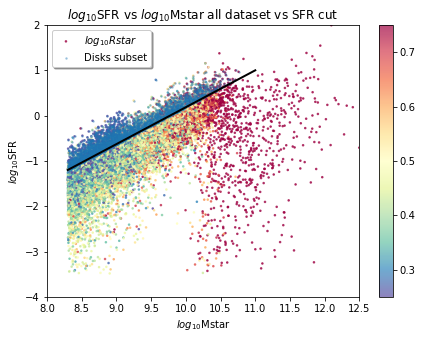

In [35]:
# Plot of log SFR vs log Mstar to see the trend and define disk galaxies

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR1 = ax.scatter(df_raw_log.SubhaloMstar_log, df_raw_log.SubhaloSFRinRad_log,
            c = df_raw_log.SubhaloRstar_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}Rstar$', vmin=0.25, vmax=0.75)
fig_SR = ax.scatter(df_sfrcut_raw_log.SubhaloMstar_log[df_sfrcut_raw_log.SubhaloSFRinRad_log >= y_hat], df_sfrcut_raw_log.SubhaloSFRinRad_log[df_sfrcut_raw_log.SubhaloSFRinRad_log >= y_hat],
            #c = df_sfrcut_raw_log2.SubhaloRstar_log, 
            s=10, marker='.', alpha=0.3,label= r'Disks subset') #, vmin=0.25, vmax=0.75)

# ax.text(-0.15, 1.35, r'$R^{2}$ score=blabla', size=12)
ax.axis([8.0,12.5, -4, 2.0])
ax.plot([8.3, 11.0], [-1.2, 1.0], color = 'black', linewidth = 2)
ax.set_title(r'$log_{10}$SFR vs $log_{10}$Mstar all dataset vs SFR cut')
ax.set_xlabel(r'$log_{10}$Mstar')
ax.legend(loc = 'upper left', shadow=True)
ax.set_ylabel(r'$log_{10}$SFR')
fig_complete.colorbar(fig_SR1, ax=ax)
# plt.savefig('TNG-SIM_images/v21_Disks_RF_FeatRank_Raw/SFR_vs_Mstar_colorRstar_Disks.jpeg', dpi=500)
plt.show()

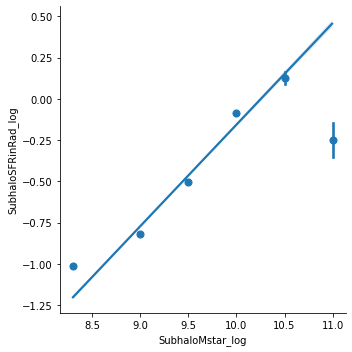

In [40]:
sns.lmplot(x = 'SubhaloMstar_log', y = 'SubhaloSFRinRad_log', data=df_sfrcut_raw_log[df_sfrcut_raw_log.SubhaloSFRinRad_log>-5],
           fit_reg=True, x_bins=[8.3,9, 9.5, 10, 10.5, 11.0],
          markers='o')
plt.show()

### <font color='purple'> <a id =10> </a> <br> Complete Raw Dataset: RF & Feature Ranking

In [41]:
df_disks.columns.to_list()

['SubhaloBHMass_log',
 'SubhaloBHMdot_log',
 'SubhaloGasMetallicity_log',
 'SubhaloSFRinRad_log',
 'SubhaloStarMetallicity_log',
 'SubhaloVelDisp_log',
 'SubhaloVmax_log',
 'SubhaloVmaxRad_log',
 'SubhaloRgas_log',
 'SubhaloRstar_log',
 'SubhaloMgas_log',
 'SubhaloMstar_log',
 'GroupNsubs_log',
 'Group_M_TopHat200_log',
 'Group_R_TopHat200_log',
 'SubhaloMHI_log',
 'SubhaloMH2_log',
 'Group_V_TopHat200_log',
 'GroupSpin_dmo_log']

In [42]:
X_all = df_disks.drop(columns=['SubhaloRstar_log'])
 

y_all = df_disks.loc[:,'SubhaloRstar_log']

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best params, best score: 0.8455 {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700}
RF Accuracy: 0.84 (+/- 0.02)


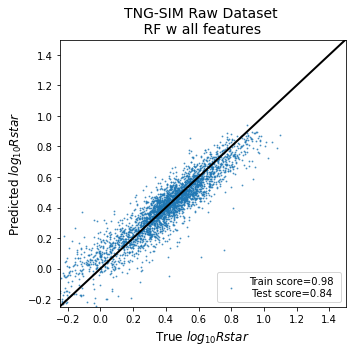

Elapsed time to compute the importances: 0.105 seconds


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Elapsed time to compute the importances: 14.405 seconds


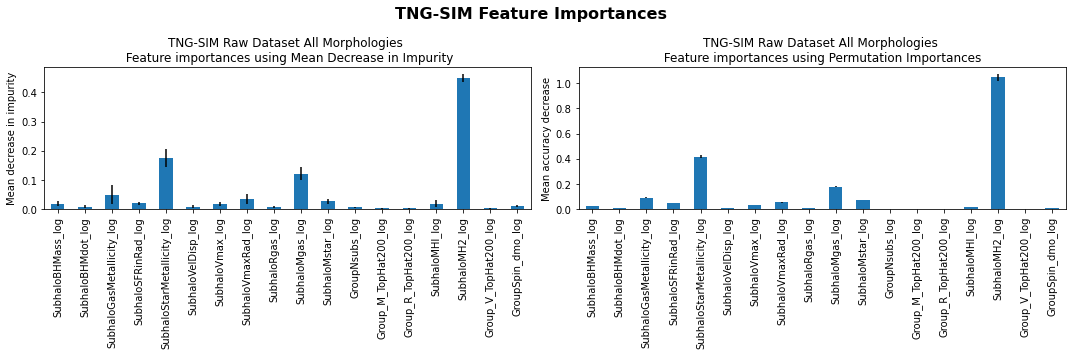

  0%|                                                    | 0/18 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits


  6%|██▍                                         | 1/18 [00:16<04:32, 16.03s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits


 11%|████▉                                       | 2/18 [00:33<04:25, 16.60s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits


 17%|███████▎                                    | 3/18 [00:50<04:14, 16.98s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 22%|█████████▊                                  | 4/18 [01:06<03:54, 16.74s/it]

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt,

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, 

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, mi

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt,

 28%|████████████▏                               | 5/18 [01:25<03:47, 17.46s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   

 33%|██████████████▋                             | 6/18 [01:43<03:31, 17.62s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500;

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 39%|█████████████████                           | 7/18 [02:00<03:10, 17.32s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_feature

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, mi

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=aut

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt,

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_fea

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=No

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 44%|███████████████████▌                        | 8/18 [02:18<02:54, 17.48s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits


 50%|██████████████████████                      | 9/18 [02:35<02:37, 17.46s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 

 56%|███████████████████████▉                   | 10/18 [02:52<02:19, 17.39s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, mi

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto,

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 61%|██████████████████████████▎                | 11/18 [03:10<02:01, 17.40s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   

 67%|████████████████████████████▋              | 12/18 [03:21<01:32, 15.45s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimat

 72%|███████████████████████████████            | 13/18 [03:38<01:20, 16.11s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=N

 78%|█████████████████████████████████▍         | 14/18 [03:55<01:05, 16.44s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimator

 83%|███████████████████████████████████▊       | 15/18 [04:15<00:51, 17.25s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1

 89%|██████████████████████████████████████▏    | 16/18 [06:19<01:39, 49.64s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, 

 94%|███████████████████████████████████████▋  | 17/18 [11:15<02:03, 123.50s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimato

100%|███████████████████████████████████████████| 18/18 [12:59<00:00, 43.28s/it]


1. iteration: 
	 1 SubhaloMH2_log 0.44648421374232966


  0%|                                                    | 0/17 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, 

  6%|██▌                                         | 1/17 [00:18<04:50, 18.14s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time= 

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_fea

 12%|█████▏                                      | 2/17 [00:38<04:51, 19.44s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimato

 18%|███████▊                                    | 3/17 [00:58<04:35, 19.64s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  

 24%|██████████▎                                 | 4/17 [01:17<04:13, 19.49s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, m

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, m

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqr

 29%|████████████▉                               | 5/17 [01:36<03:50, 19.19s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total tim

 35%|███████████████▌                            | 6/17 [01:55<03:30, 19.15s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_featu

 41%|██████████████████                          | 7/17 [02:15<03:14, 19.43s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, 

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, m

 47%|████████████████████▋                       | 8/17 [02:35<02:57, 19.71s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits


 53%|███████████████████████▎                    | 9/17 [02:55<02:38, 19.85s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimato

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, 

 59%|█████████████████████████▎                 | 10/17 [03:16<02:20, 20.06s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimato

 65%|███████████████████████████▊               | 11/17 [03:36<01:59, 19.93s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total tim

 71%|██████████████████████████████▎            | 12/17 [03:54<01:36, 19.36s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; t

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=2

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min

 76%|████████████████████████████████▉          | 13/17 [04:13<01:17, 19.41s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits


 82%|███████████████████████████████████▍       | 14/17 [04:33<00:58, 19.65s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=2

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, mi

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=

 88%|█████████████████████████████████████▉     | 15/17 [04:53<00:39, 19.79s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits


 94%|████████████████████████████████████████▍  | 16/17 [05:13<00:19, 19.72s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits


100%|███████████████████████████████████████████| 17/17 [05:33<00:00, 19.62s/it]


2. iteration: 
	 1 SubhaloMH2_log 0.44648421374232966
	 2 SubhaloStarMetallicity_log 0.7097757267194159


  0%|                                                    | 0/16 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, 

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=Non

  6%|██▊                                         | 1/16 [00:23<05:55, 23.69s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimato

 12%|█████▌                                      | 2/16 [00:47<05:31, 23.71s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits


 19%|████████▎                                   | 3/16 [01:09<04:58, 22.99s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total 

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, 

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=None

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, 

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, 

 25%|███████████                                 | 4/16 [01:32<04:35, 22.96s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits


 31%|█████████████▊                              | 5/16 [01:54<04:09, 22.69s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; to

 38%|████████████████▌                           | 6/16 [02:17<03:47, 22.76s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=5

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, m

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, 

 44%|███████████████████▎                        | 7/16 [02:41<03:27, 23.00s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   

 50%|██████████████████████                      | 8/16 [03:05<03:07, 23.40s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, m

 56%|████████████████████████▊                   | 9/16 [03:28<02:43, 23.36s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, 

 62%|██████████████████████████▉                | 10/16 [03:52<02:21, 23.50s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimator

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, m

 69%|█████████████████████████████▌             | 11/16 [04:13<01:54, 22.90s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=  

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, m

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=au

 75%|████████████████████████████████▎          | 12/16 [04:37<01:32, 23.08s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50

 81%|██████████████████████████████████▉        | 13/16 [05:00<01:09, 23.10s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_featu

 88%|█████████████████████████████████████▋     | 14/16 [05:24<00:46, 23.48s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total

 94%|████████████████████████████████████████▎  | 15/16 [05:47<00:23, 23.33s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, 

100%|███████████████████████████████████████████| 16/16 [06:10<00:00, 23.19s/it]


3. iteration: 
	 1 SubhaloMH2_log 0.44648421374232966
	 2 SubhaloStarMetallicity_log 0.7097757267194159
	 3 SubhaloMstar_log 0.8119735201725068


  0%|                                                    | 0/15 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; t

  7%|██▉                                         | 1/15 [00:29<06:48, 29.21s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total t

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_fe

 13%|█████▊                                      | 2/15 [00:59<06:25, 29.68s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, 

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, mi

 20%|████████▊                                   | 3/15 [01:28<05:53, 29.45s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimato

 27%|███████████▋                                | 4/15 [01:58<05:25, 29.63s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; t

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, mi

 33%|██████████████▋                             | 5/15 [02:28<04:57, 29.72s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, 

 40%|█████████████████▌                          | 6/15 [02:58<04:28, 29.79s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   

 47%|████████████████████▌                       | 7/15 [03:28<03:58, 29.87s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, m

 53%|███████████████████████▍                    | 8/15 [03:58<03:30, 30.12s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, 

 60%|██████████████████████████▍                 | 9/15 [04:28<03:00, 30.03s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, 

 67%|████████████████████████████▋              | 10/15 [04:56<02:27, 29.48s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0

 73%|███████████████████████████████▌           | 11/15 [05:25<01:56, 29.18s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=N

 80%|██████████████████████████████████▍        | 12/15 [05:55<01:28, 29.47s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_

 87%|█████████████████████████████████████▎     | 13/15 [06:26<00:59, 29.81s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 

 93%|████████████████████████████████████████▏  | 14/15 [06:56<00:29, 29.85s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=N

100%|███████████████████████████████████████████| 15/15 [07:26<00:00, 29.79s/it]


4. iteration: 
	 1 SubhaloMH2_log 0.44648421374232966
	 2 SubhaloStarMetallicity_log 0.7097757267194159
	 3 SubhaloMstar_log 0.8119735201725068
	 4 SubhaloVmaxRad_log 0.8220932809619369


  0%|                                                    | 0/14 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, mi

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features

  7%|███▏                                        | 1/14 [00:32<07:01, 32.42s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, m

 14%|██████▎                                     | 2/14 [01:05<06:31, 32.65s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  

 21%|█████████▍                                  | 3/14 [01:38<06:00, 32.74s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total 

 29%|████████████▌                               | 4/14 [02:10<05:27, 32.73s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.9s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.9s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   2.0s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, 

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, m

 36%|███████████████▋                            | 5/14 [02:43<04:55, 32.79s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=N

 43%|██████████████████▊                         | 6/14 [03:16<04:22, 32.80s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 

 50%|██████████████████████                      | 7/14 [03:49<03:49, 32.81s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, m

 57%|█████████████████████████▏                  | 8/14 [04:22<03:17, 32.92s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimato

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_fe

 64%|████████████████████████████▎               | 9/14 [04:55<02:44, 32.81s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits


 71%|██████████████████████████████▋            | 10/14 [05:29<02:12, 33.18s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimator

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, m

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=

 79%|█████████████████████████████████▊         | 11/14 [06:03<01:40, 33.45s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total ti

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, 

 86%|████████████████████████████████████▊      | 12/14 [06:37<01:07, 33.66s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0

 93%|███████████████████████████████████████▉   | 13/14 [07:11<00:33, 33.86s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimat

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqr

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max

100%|███████████████████████████████████████████| 14/14 [07:43<00:00, 33.13s/it]


5. iteration: 
	 1 SubhaloMH2_log 0.44648421374232966
	 2 SubhaloStarMetallicity_log 0.7097757267194159
	 3 SubhaloMstar_log 0.8119735201725068
	 4 SubhaloVmaxRad_log 0.8220932809619369
	 5 SubhaloGasMetallicity_log 0.8385484129368587


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100;

  8%|███▍                                        | 1/13 [00:35<07:08, 35.70s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.9s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.9s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=Non

 15%|██████▊                                     | 2/13 [01:11<06:32, 35.65s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt

 23%|██████████▏                                 | 3/13 [01:47<05:57, 35.71s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimato

 31%|█████████████▌                              | 4/13 [02:22<05:21, 35.70s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimato

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, 

 38%|████████████████▉                           | 5/13 [02:58<04:45, 35.73s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, m

 46%|████████████████████▎                       | 6/13 [03:33<04:08, 35.46s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=No

 54%|███████████████████████▋                    | 7/13 [04:09<03:34, 35.75s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 

 62%|███████████████████████████                 | 8/13 [04:46<02:59, 35.93s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total 

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, 

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, ma

 69%|██████████████████████████████▍             | 9/13 [05:21<02:23, 35.81s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; to

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt,

 77%|█████████████████████████████████          | 10/13 [05:57<01:47, 35.84s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0

 85%|████████████████████████████████████▍      | 11/13 [06:33<01:11, 35.84s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_fea

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=au

 92%|███████████████████████████████████████▋   | 12/13 [07:09<00:35, 35.86s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=Non

100%|███████████████████████████████████████████| 13/13 [07:45<00:00, 35.80s/it]


6. iteration: 
	 1 SubhaloMH2_log 0.44648421374232966
	 2 SubhaloStarMetallicity_log 0.7097757267194159
	 3 SubhaloMstar_log 0.8119735201725068
	 4 SubhaloVmaxRad_log 0.8220932809619369
	 5 SubhaloGasMetallicity_log 0.8385484129368587
	 6 SubhaloSFRinRad_log 0.8491923425890361


  0%|                                                    | 0/12 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total 

  8%|███▋                                        | 1/12 [00:38<07:04, 38.61s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=

 17%|███████▎                                    | 2/12 [01:17<06:27, 38.70s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimat

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=N

 25%|███████████                                 | 3/12 [01:54<05:42, 38.04s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimato

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.9s
[CV] END bootstrap=True, max_depth=2,

 33%|██████████████▋                             | 4/12 [02:33<05:06, 38.30s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=Non

 42%|██████████████████▎                         | 5/12 [03:12<04:29, 38.54s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimat

 50%|██████████████████████                      | 6/12 [03:53<03:56, 39.47s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=Non

 58%|█████████████████████████▋                  | 7/12 [04:30<03:13, 38.61s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=5

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   2.5s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, mi

 67%|█████████████████████████████▎              | 8/12 [05:08<02:34, 38.58s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time= 

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_featu

 75%|█████████████████████████████████           | 9/12 [05:49<01:57, 39.31s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total tim

 83%|███████████████████████████████████▊       | 10/12 [06:27<01:17, 38.68s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt,

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_featu

 92%|███████████████████████████████████████▍   | 11/12 [07:05<00:38, 38.70s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimator

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   2.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, 

100%|███████████████████████████████████████████| 12/12 [07:44<00:00, 38.75s/it]


7. iteration: 
	 1 SubhaloMH2_log 0.44648421374232966
	 2 SubhaloStarMetallicity_log 0.7097757267194159
	 3 SubhaloMstar_log 0.8119735201725068
	 4 SubhaloVmaxRad_log 0.8220932809619369
	 5 SubhaloGasMetallicity_log 0.8385484129368587
	 6 SubhaloSFRinRad_log 0.8491923425890361
	 7 SubhaloVelDisp_log 0.848176900279363


  0%|                                                    | 0/11 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   

  9%|████                                        | 1/11 [00:41<06:53, 41.38s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto,

 18%|████████                                    | 2/11 [01:21<06:08, 40.93s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time= 

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, mi

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, 

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, 

 27%|████████████                                | 3/11 [02:07<05:44, 43.04s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits


 36%|████████████████                            | 4/11 [02:52<05:07, 43.95s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=

 45%|████████████████████                        | 5/11 [03:35<04:21, 43.52s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.8s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.0s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.9s
[CV] END bootstrap=True, max_depth=5, max_features=auto

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.9s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, m

 55%|████████████████████████                    | 6/11 [04:20<03:39, 43.90s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   2.9s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   

 64%|████████████████████████████                | 7/11 [05:07<02:59, 44.89s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt

 73%|████████████████████████████████            | 8/11 [05:52<02:15, 45.17s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   5.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.9s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, 

 82%|████████████████████████████████████        | 9/11 [06:38<01:30, 45.38s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  

 91%|███████████████████████████████████████    | 10/11 [07:24<00:45, 45.59s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, mi

100%|███████████████████████████████████████████| 11/11 [08:08<00:00, 44.44s/it]


8. iteration: 
	 1 SubhaloMH2_log 0.44648421374232966
	 2 SubhaloStarMetallicity_log 0.7097757267194159
	 3 SubhaloMstar_log 0.8119735201725068
	 4 SubhaloVmaxRad_log 0.8220932809619369
	 5 SubhaloGasMetallicity_log 0.8385484129368587
	 6 SubhaloSFRinRad_log 0.8491923425890361
	 7 SubhaloVelDisp_log 0.848176900279363
	 8 SubhaloBHMass_log 0.8484477386961887


  0%|                                                    | 0/10 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_featu

 10%|████▍                                       | 1/10 [00:50<07:35, 50.62s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, mi

 20%|████████▊                                   | 2/10 [01:41<06:44, 50.50s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   

 30%|█████████████▏                              | 3/10 [02:31<05:54, 50.64s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; to

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.9s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.1s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, 

 40%|█████████████████▌                          | 4/10 [03:22<05:03, 50.65s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  

 50%|██████████████████████                      | 5/10 [04:11<04:09, 49.93s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 

 60%|██████████████████████████▍                 | 6/10 [05:03<03:23, 50.91s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqr

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_feat

 70%|██████████████████████████████▊             | 7/10 [05:53<02:31, 50.54s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, 

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, ma

 80%|███████████████████████████████████▏        | 8/10 [06:44<01:40, 50.47s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=  

 90%|███████████████████████████████████████▌    | 9/10 [07:33<00:50, 50.28s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; 

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, 

100%|███████████████████████████████████████████| 10/10 [08:24<00:00, 50.42s/it]


9. iteration: 
	 1 SubhaloMH2_log 0.44648421374232966
	 2 SubhaloStarMetallicity_log 0.7097757267194159
	 3 SubhaloMstar_log 0.8119735201725068
	 4 SubhaloVmaxRad_log 0.8220932809619369
	 5 SubhaloGasMetallicity_log 0.8385484129368587
	 6 SubhaloSFRinRad_log 0.8491923425890361
	 7 SubhaloVelDisp_log 0.848176900279363
	 8 SubhaloBHMass_log 0.8484477386961887
	 9 GroupSpin_dmo_log 0.853402679728748


  0%|                                                     | 0/9 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   3.0s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, m

 11%|█████                                        | 1/9 [00:52<07:03, 52.96s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total tim

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=au

 22%|██████████                                   | 2/9 [01:45<06:10, 52.88s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimato

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.4s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, m

 33%|███████████████                              | 3/9 [02:39<05:18, 53.06s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s


 44%|████████████████████                         | 4/9 [03:32<04:26, 53.22s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_featur

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=None,

 56%|█████████████████████████                    | 5/9 [04:24<03:30, 52.69s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   3.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   3.7s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time= 

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=2

 67%|██████████████████████████████               | 6/9 [05:15<02:36, 52.26s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimator

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min

 78%|███████████████████████████████████          | 7/9 [06:12<01:47, 53.82s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.7s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   

 89%|████████████████████████████████████████     | 8/9 [07:05<00:53, 53.56s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features

100%|█████████████████████████████████████████████| 9/9 [08:01<00:00, 53.55s/it]

10. iteration: 
	 1 SubhaloMH2_log 0.44648421374232966
	 2 SubhaloStarMetallicity_log 0.7097757267194159
	 3 SubhaloMstar_log 0.8119735201725068
	 4 SubhaloVmaxRad_log 0.8220932809619369
	 5 SubhaloGasMetallicity_log 0.8385484129368587
	 6 SubhaloSFRinRad_log 0.8491923425890361
	 7 SubhaloVelDisp_log 0.848176900279363
	 8 SubhaloBHMass_log 0.8484477386961887
	 9 GroupSpin_dmo_log 0.853402679728748
	 10 SubhaloVmax_log 0.8523673806129967


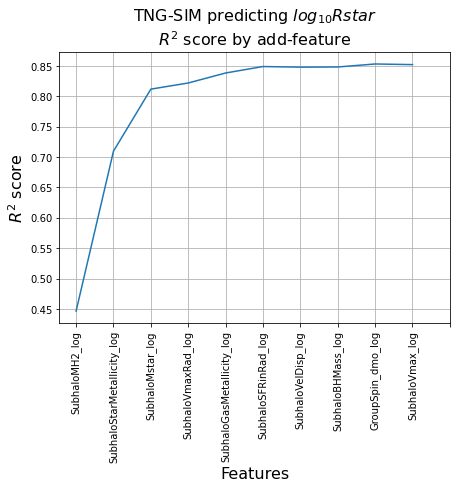

Elapsed time to run RF func on Raw TNG-SIM: 5725.835 seconds
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   3.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   3.7s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, 

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, m

In [43]:
# this code takes 50293.695 seconds ~ 14 hrs to run when the dataset is TNG-SIM galaxies with ~22,000 entries
# and 19 features (480 models for the RF (total 2400 fits);
# 288 models for each add-on feature ranking step, cv=3, so 864 fits )
start_time = time.time()

RF_results_all = functions.target_predicting_RF_function(X=X_all, y=y_all)

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func on Raw TNG-SIM: {elapsed_time:.3f} seconds")

Fitting 5 folds for each of 480 candidates, totalling 2400 fits

Best params, best score: 0.8455 {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700}

RF Accuracy: 0.84 (+/- 0.02)

<!--     n_estimators = [20, 50,100, 500, 700]
    # create random grid
    grid = {'bootstrap': [True],
                   'max_depth': [2, 5, 10, None],
                   'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [1, 2, 4, 8],
                   'min_samples_split': [2, 5, 10],
                   'n_estimators': n_estimators}
    # Grid search of parameters
    rfr_grid = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = KFold(n_splits=5, shuffle=True),                          verbose = 1, n_jobs = -1, return_train_score=True)

For feature ranking:

Fitting 3 folds for each of 288 candidates, totalling 864 fits

    n_estimators = [50,100, 500]
    grid = {'bootstrap': [True],
                   'max_depth': [2, 5, None],
                   'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [1, 2, 4],
                   'min_samples_split': [2, 5],
                   'n_estimators': n_estimators} -->

#### The most important features, Raw Dataset of Disks Morphology (TNG100-SIM, log10features predicting log10Rstar) are:

	feature_number	features	r_sq_score
	1	SubhaloMH2_log	0.446484
	2	SubhaloStarMetallicity_log	0.709776
	3	SubhaloMstar_log	0.811974
	4	SubhaloVmaxRad_log	0.822093
	5	SubhaloGasMetallicity_log	0.838548
	6	SubhaloSFRinRad_log	0.849192
	7	SubhaloVelDisp_log	0.848177
	8	SubhaloBHMass_log	0.848448
	9	GroupSpin_dmo_log	0.85340
    10	SubhaloVmax_log	0.852367



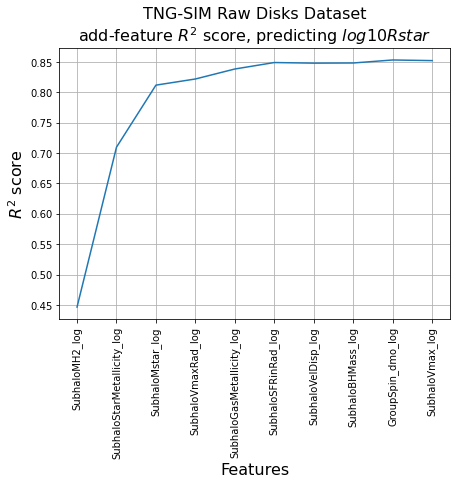

In [44]:
all_0D_fig_add_feature=RF_results_all[4].plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                    legend=False, grid=True, 
                    xticks=range(0,10))
all_0D_fig_add_feature.set_title(label= r'TNG-SIM Raw Disks Dataset' + '\n' + r'add-feature $R^{2}$ score, predicting $log{10}Rstar$',fontsize=16)
all_0D_fig_add_feature.set_xlabel('Features',fontsize=16)
all_0D_fig_add_feature.set_ylabel(r'$R^{2}$ score',fontsize=16)

# all_0D_fig_add_feature.get_figure().savefig('TNG-SIM_images/v21_Disks_RF_FeatRank_Raw/v21_Disks_TNG-SIM_Raw_R_score_by_add_feature.jpg', dpi=500)

plt.show()

In [45]:
# RF_results_all[4].to_csv('TNG-SIM_images/v21_Disks_RF_FeatRank_Raw/v21_Disks_TNG_Raw_Max_r_scores_by_add_column_method.csv', index=False)

all_raw = pd.read_csv('TNG-SIM_images/v21_Disks_RF_FeatRank_Raw/v21_Disks_TNG_Raw_Max_r_scores_by_add_column_method.csv')

all_raw_fig = RF_results_all[1]
# all_raw_fig.savefig('TNG-SIM_images/v21_Disks_RF_FeatRank_Raw/v21_Disks_TNG_Raw_RF_Prediction_vs_True.jpeg', dpi=500)
plt.show()

all_raw_fig_builtin_imp = RF_results_all[2]
# all_raw_fig_builtin_imp.savefig('TNG-SIM_images/v21_Disks_RF_FeatRank_Raw/v21_Disks_TNG_Raw_Built_in_Feature_Ranking.jpeg', dpi=500)
plt.show()

In [89]:
all_raw

feature_number                    features  r_sq_score
0               1              SubhaloMH2_log    0.446484
1               2  SubhaloStarMetallicity_log    0.709776
2               3            SubhaloMstar_log    0.811974
3               4          SubhaloVmaxRad_log    0.822093
4               5   SubhaloGasMetallicity_log    0.838548
5               6         SubhaloSFRinRad_log    0.849192
6               7          SubhaloVelDisp_log    0.848177
7               8           SubhaloBHMass_log    0.848448
8               9           GroupSpin_dmo_log    0.853403
9              10             SubhaloVmax_log    0.852367

In [46]:
# y_pred_RF_df_all = RF_results_all[0]
# y_pred_RF_df_all = pd.DataFrame({'y_pred_RF SIM Raw': y_pred_RF_df_all})

# y_pred_RF_df_all.to_csv('TNG-SIM_images/v21_Disks_RF_FeatRank_Raw/v21_Disks_TNG-SIM_Raw_y_pred_RF_predicted_sizes.csv', index=False)

y_pred_RF_all = pd.read_csv('TNG-SIM_images/v21_Disks_RF_FeatRank_Raw/v21_Disks_TNG-SIM_Raw_y_pred_RF_predicted_sizes.csv')

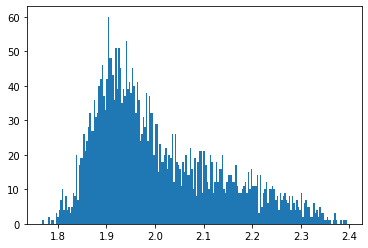

In [83]:
plt.hist(df_disks.SubhaloVmax_log, bins=200)
plt.show()

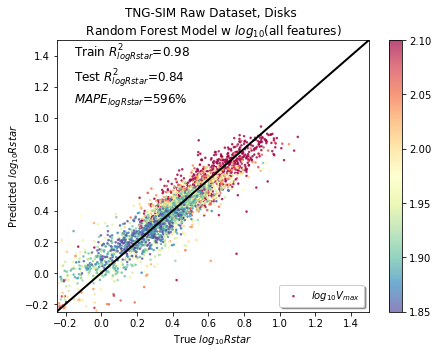

In [87]:
# Plot of Predicted log10 Raw Rstar vs True log 10 Raw Rstar

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_disks.SubhaloRstar_log, y_pred_RF_all,
            c = df_disks.SubhaloVmax_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}V_{max}$', vmin=1.85, vmax=2.1)
ax.text(-0.15, 1.1, r'Train $R^{2}_{logRstar}$=0.98' + '\n' + r'Test $R^{2}_{logRstar}$=0.84' + '\n' + r'$MAPE_{logRstar}$=596$\%$ ', size=12)
ax.axis([-0.25,1.5, -0.25,1.5])
ax.plot([-1.0, 2.0], [-1.0, 2.0], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM Raw Dataset, Disks \n ' + r'Random Forest Model w $log_{10}$(all features) ')
ax.set_xlabel(r'True $log_{10}Rstar$')
ax.set_ylabel(r'Predicted $log_{10}Rstar$')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v21_Disks_RF_FeatRank_Raw/v21_Disks_TNG-SIM_Raw_RF_size_pred_colorlogVmaxVvir_1.jpeg', dpi=500)
plt.show()

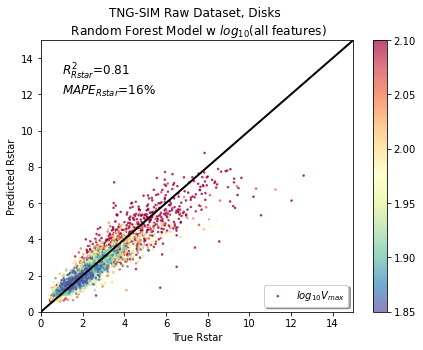

In [88]:
# Plot of Predicted Raw Rstar vs Raw Rstar 

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(10**(df_disks.SubhaloRstar_log), 10**(y_pred_RF_all),
            c = df_disks.SubhaloVmax_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}V_{max}$', vmin=1.85, vmax=2.1)
ax.text(1.0, 12, r'$R^{2}_{Rstar}$=0.81' + '\n' + r'$MAPE_{Rstar}$=16$\%$ ', size=12)
ax.axis([0.0,15, 0.0,15])
ax.plot([0, 30], [0, 30], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM Raw Dataset, Disks \n ' + r'Random Forest Model w $log_{10}$(all features) ')
ax.set_xlabel(r'True Rstar')
ax.set_ylabel(r'Predicted Rstar')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v21_Disks_RF_FeatRank_Raw/v21_Disks_TNG-SIM_Raw_RF_size_pred_colorlogVmaxVvir_2.jpeg', dpi=500)
plt.show()

### Other metrics

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

##### <font color='darkgreen'> <a id =10> </a> <br>log(Rstar) metrics

In [73]:
print('MSE:', mean_squared_error(df_disks.loc[:, 'SubhaloRstar_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM Raw']))
print('sqrtMSE:', np.sqrt(mean_squared_error(df_disks.loc[:, 'SubhaloRstar_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM Raw'])))
print('MAE:', mean_absolute_error(df_disks.loc[:, 'SubhaloRstar_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM Raw']))
# MAPE in log scale
print('MAPE:', mean_absolute_percentage_error(df_disks.loc[:, 'SubhaloRstar_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM Raw']))
# r2 score in log scale
print('R2_logRstar:', r2_score(df_disks.loc[:, 'SubhaloRstar_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM Raw']))

MSE: 0.008609119465240022
sqrtMSE: 0.09278534078851046
MAE: 0.06898740067408227
MAPE: 5.9621313763246215
R2_logRstar: 0.8430043445517171


##### <font color='darkgreen'> <a id =10> </a> <br> Rstar metrics

In [74]:
print('MSE:', mean_squared_error(10**df_disks.loc[:, 'SubhaloRstar_log'], 10**y_pred_RF_all.loc[:,'y_pred_RF SIM Raw']))
print('sqrtMSE:', np.sqrt(10**mean_squared_error(df_disks.loc[:, 'SubhaloRstar_log'], 10**y_pred_RF_all.loc[:,'y_pred_RF SIM Raw'])))
print('MAE:', mean_absolute_error(10**df_disks.loc[:, 'SubhaloRstar_log'], 10**y_pred_RF_all.loc[:,'y_pred_RF SIM Raw']))
# MAPE in original variables
print('MAPE:', mean_absolute_percentage_error(10**(df_disks.loc[:, 'SubhaloRstar_log']), 10**(y_pred_RF_all.loc[:,'y_pred_RF SIM Raw'])))
# r2score in original variables
print('R2_Rstar:', r2_score(10**(df_disks.loc[:, 'SubhaloRstar_log']), 10**(y_pred_RF_all.loc[:,'y_pred_RF SIM Raw'])))

MSE: 0.4304972402264819
sqrtMSE: 3043.749690255622
MAE: 0.43413046446007664
MAPE: 0.16225527062973943
R2_Rstar: 0.8136307011569854


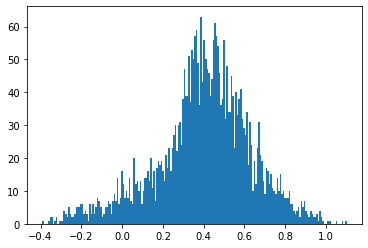

In [56]:
plt.hist(df_disks.loc[:, 'SubhaloRstar_log'], bins=200)
plt.show()

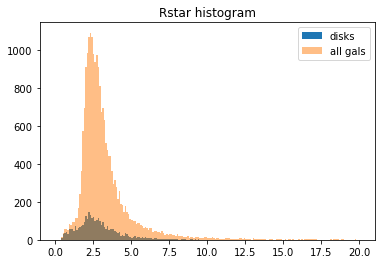

In [79]:
plt.hist(10**(df_disks.loc[:, 'SubhaloRstar_log']), bins=200, range=(0,20), label='disks')
plt.hist(df_raw.loc[:, 'SubhaloRstar'], bins=200, range=(0,20), alpha=0.5, label='all gals')
plt.title(r'Rstar histogram')
plt.legend(loc='upper right')
# plt.savefig('TNG-SIM_images/v21_Disks_RF_FeatRank_Raw/Rstar_hist_disk_vs_all.jpeg', dpi=500)
plt.show()

### Learning Curve

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params, best score: 0.8458 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
RF Accuracy: 0.84 (+/- 0.02)


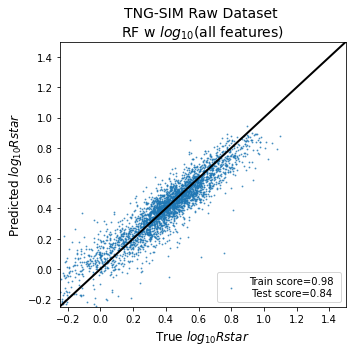

Elapsed time to compute the importances: 0.078 seconds


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Elapsed time to compute the importances: 9.512 seconds


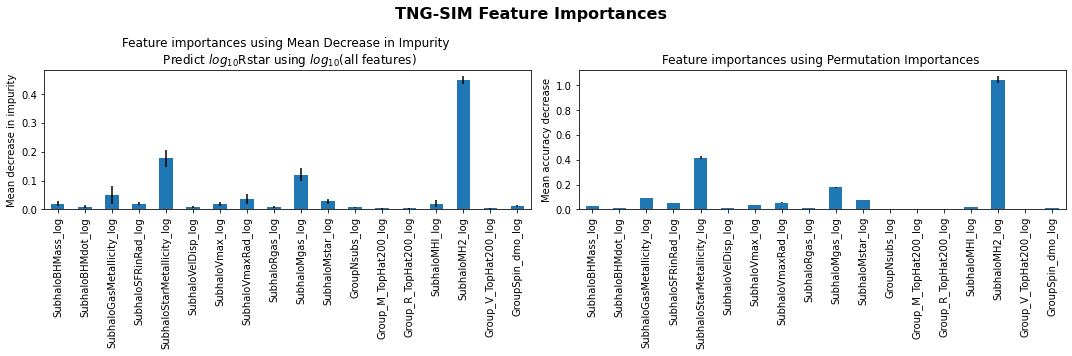

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


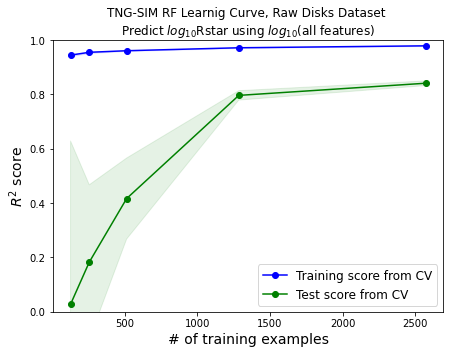

Elapsed time to run RF func and Learning Curves on TNG-SIM Raw Disks Dataset: 175.495 seconds


In [64]:
# this code takes 2242.162 seconds ~37min to run when the dataset is TNG100-SIM galaxies
# with ~22,000 entries 
start_time = time.time()

RF_lc_2 = tp_lc_functions.target_predicting_RF_function(X_all, y_all, 'TNG-SIM RF Learnig Curve, Raw Disks Dataset \n'+r'Predict $log_{10}$Rstar using $log_{10}$(all features)')

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func and Learning Curves on TNG-SIM Raw Disks Dataset: {elapsed_time:.3f} seconds")

In [65]:
lc_2 = RF_lc_2[4]
# lc_2.savefig('TNG-SIM_images/v21_Disks_RF_FeatRank_Raw/v21_Disks_TNG-SIM_Raw_RF_Learning_Curve_zoom.jpeg', dpi=500)
lc_3 = RF_lc_2[2]
# lc_3.savefig('TNG-SIM_images/v21_Disks_RF_FeatRank_Raw/v21_Disks_TNG-SIM_Raw_PermutationImportances.jpeg', dpi=500)
# RF_lc_2[3].to_csv('TNG-SIM_images/v21_Disks_RF_FeatRank_Raw/v21_Disks_TNG_Raw_PermutationImportances.csv', index=False)
